In [1]:
import numpy as np
import scipy.stats as sps
from glob import glob
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
sys.path.append('../lib')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from lumi_utilities import getLumiReport

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Preliminary"

donotdelete = []

Welcome to JupyROOT 6.10/08


In [2]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [3]:
m_D0 = 1.86483 #1e-3*Particle.from_string('D0').mass
print m_D0
m_Dst = 2.01026 #1e-3*Particle.from_string('D*+').mass
print m_Dst
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass
print m_B0
m_pi = 0.13957018 #1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

1.86483
2.01026
5.27963
mD* - mD0 = 0.14543


In [4]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

# Load data

In [5]:
dataDir = '../data/cmsRD'
datasets_loc = []
# datasets_loc += glob(dataDir + '/ParkingBPH[12]/*B2JpsiKst_191002*')
# datasets_loc += glob(dataDir + '/ParkingBPH3/*B2JpsiKst_191003*')

datasets_loc += glob(dataDir + '/ParkingBPH1/*2018D-*B2JpsiKst_191011*')

In [6]:
lumi_tot, lumi_dic = getLumiReport(datasets_loc)
CMS_lumi.integrated_lumi = lumi_tot

Lumi tot: 8.5 fb^-1
Lumi analyzed: 20.7%


In [7]:
f = datasets_loc[0]
t = ur.open(f)['outA']['Tevts']
# print tMC.keys(), '\n\n'
branches = t.keys()
for b in np.sort(branches):
#     pass
    print b

B_JpsiKst_cBMass_eta
B_JpsiKst_cBMass_phi
B_JpsiKst_cBMass_pt
B_JpsiKst_eta
B_JpsiKst_phi
B_JpsiKst_pt
B_mumupiK_cBMass_eta
B_mumupiK_cBMass_phi
B_mumupiK_cBMass_pt
B_mumupiK_cJpsiKstMassPointing_eta
B_mumupiK_cJpsiKstMassPointing_phi
B_mumupiK_cJpsiKstMassPointing_pt
B_mumupiK_cJpsiKstMass_eta
B_mumupiK_cJpsiKstMass_phi
B_mumupiK_cJpsiKstMass_pt
B_mumupiK_cPointing_eta
B_mumupiK_cPointing_phi
B_mumupiK_cPointing_pt
B_mumupiK_eta
B_mumupiK_phi
B_mumupiK_pt
B_mumupiKrefit_cBmass_eta
B_mumupiKrefit_cBmass_phi
B_mumupiKrefit_cBmass_pt
B_mumupiKrefit_eta
B_mumupiKrefit_phi
B_mumupiKrefit_pt
KRefit_eta
KRefit_phi
KRefit_pt
K_N_valid_hits
K_eta
K_norm_chi2
K_phi
K_pt
K_sigdxy_PV
LumiBlock
N_vertexes
Run
chi2_JpsiKst
chi2_JpsiKst_cBMass
chi2_mumu
chi2_mumu_cJpsiMass
chi2_mumupiK
chi2_mumupiK_cBMass
chi2_mumupiK_cJpsiKstMass
chi2_mumupiK_cJpsiKstMassPointing
chi2_mumupiK_cPointing
chi2_mumupiKrefit
chi2_mumupiKrefit_cBmass
chi2_piK
chi2_piK_cKstMass
cos_B_PV_JpsiKst
cos_B_PV_JpsiKst_cBMass
cos

In [8]:
d = extarct_multiple(datasets_loc, branches=branches, flag='data')
print 'Number of events:', d['n_B'].shape[0]
print 'Number of candidates:', d['mass_JpsiKst'].shape[0]

Number of events: 827850
Number of candidates: 1184304


# Cuts declaration

In [9]:
import operator
ops = {'>': operator.gt, '<': operator.lt, }

def createSel(d, cut):
    k_ref = cut.keys()[0]
    if k_ref[0] == '_': 
            k_ref = k_ref[1:]
    sel = np.ones_like(d[k_ref], dtype=bool)
    for k, v in cut.iteritems():
        if k[0] == '_': 
            k = k[1:]
        sel = np.logical_and(sel, ops[v[0]](d[k], v[1]) )
        
    eff = np.sum(sel)/float(sel.shape[0])
    return sel, eff

# Selection

In [10]:
cut = {}

####----- Trigger-like cuts -----#
cut['mum_pt'] = ['>', 3.5]
cut['mup_pt'] = ['>', 3.5]
# cut['Jpsi_pt'] = ['>', 6.9]
cut['sigdxy_vtxJpsi_PV'] = ['>', 3]
cut['pval_mumu'] = ['>', 0.1]
cut['mum_eta'] = ['>', -2.2]
cut['mup_eta'] = ['>', -2.2]
cut['_mum_eta'] = ['<', 2.2]
cut['_mup_eta'] = ['<', 2.2]
# Missing: dca_mumu < 0.5 cm
cut['cos_Jpsi_PV'] = ['>', 0.9]

####----- Muon systems cuts -----#
cut['mum_dxy'] = ['<', 3]
cut['mup_dxy'] = ['<', 3]

####----- Hadron systems cuts -----#
cut['K_pt'] = ['>', 0.8]
cut['pi_pt'] = ['>', 0.8]
cut['K_sigdxy_PV'] = ['>', 2]
cut['pi_sigdxy_PV'] = ['>', 2]
cut['cos_Kst_PV'] = ['>', 0.9]
cut['pval_piK'] = ['>', 0.1]

In [11]:
sel_prelim, eff = createSel(d, cut)
print eff

n_B_cand = np.repeat(d['n_B'], d['n_B'].astype(np.int))
sel_prelim = np.logical_and(sel_prelim, n_B_cand==1)

eff = float(np.sum(sel_prelim))/sel_prelim.shape[0]

print eff

0.10552864804982505
0.0741642348586


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


In [12]:
jPsi_pt = np.hypot(d['mup_pt']*np.cos(d['mup_phi'])+d['mum_pt']*np.cos(d['mum_phi']), d['mup_pt']*np.sin(d['mup_phi'])+d['mum_pt']*np.sin(d['mum_phi']))

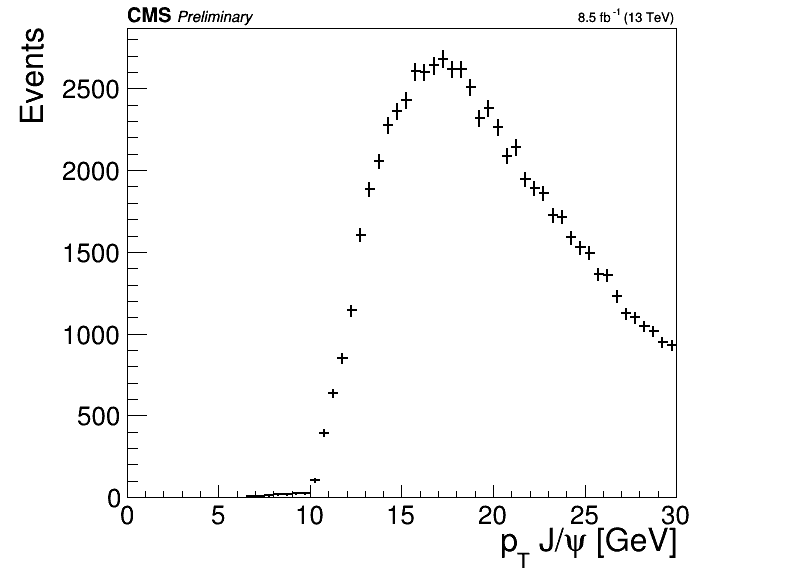

In [13]:
h = create_TH1D(jPsi_pt[sel_prelim], 
                title='',
                axis_title=['p_{T} J/#psi [GeV]', 'Events'],
                binning=[60, 0, 30]
               )
h.Sumw2()
                                   
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.SetRightMargin(0.15)
c.Draw()

# Muon system

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater


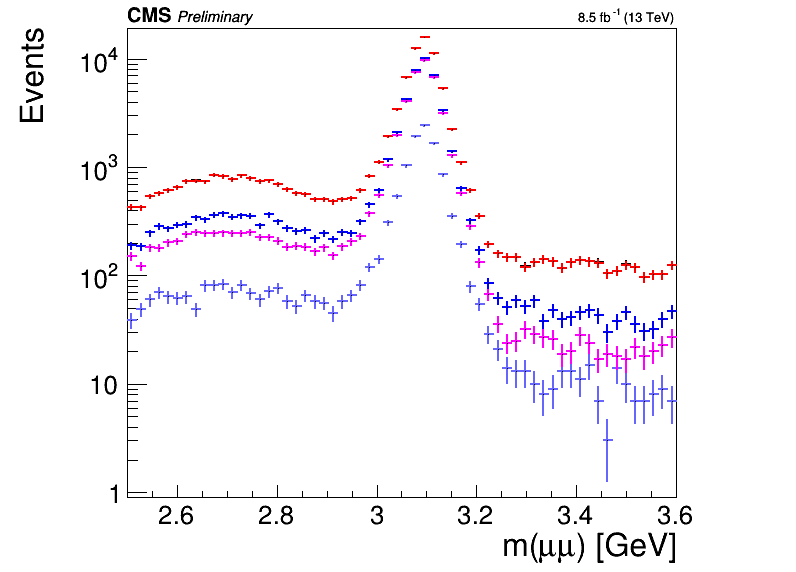

In [14]:
h = create_TH1D(d['mass_mumu'][sel_prelim], 
                title='',
                axis_title=['m(#mu#mu) [GeV]', 'Events'],
                binning=[60, 2.5, 3.6]
               )
h.Sumw2()

sel_Jpsi_pt = np.logical_and(sel_prelim, jPsi_pt >10)
h2 = create_TH1D(d['mass_mumu'][sel_Jpsi_pt], 
                title='',
                axis_title=['m(#mu#mu) [GeV]', 'Events'],
                binning=[60, 2.5, 3.6]
               )
h2.Sumw2()
h2.SetLineColor(2)

sel_ExistB = np.logical_and(sel_Jpsi_pt, d['pval_JpsiKst']>0.1)
h3 = create_TH1D(d['mass_mumu'][sel_ExistB], 
                title='',
                axis_title=['m(#mu#mu) [GeV]', 'Events'],
                binning=[60, 2.5, 3.6]
               )
h3.Sumw2()
h3.SetLineColor(rt.kBlue)

sel_ExistBmass = np.logical_and(sel_ExistB, d['isValid_JpsiKst_cBMass'])
h3_1 = create_TH1D(d['mass_mumu'][sel_ExistBmass], 
                title='',
                axis_title=['m(#mu#mu) [GeV]', 'Events'],
                binning=[60, 2.5, 3.6]
               )
h3_1.Sumw2()
h3_1.SetLineColor(rt.kBlue-7)

sel_ExistB = np.logical_and(sel_Jpsi_pt, d['pval_mumupiK']>0.1)
h4 = create_TH1D(d['mass_mumu'][sel_ExistB], 
                title='',
                axis_title=['m(#mu#mu) [GeV]', 'Events'],
                binning=[60, 2.5, 3.6]
               )
h4.Sumw2()
h4.SetLineColor(rt.kMagenta)
                                   
c = drawOnCMSCanvas(CMS_lumi, [h, h2, h3, h3_1, h4], 'same')
c.SetRightMargin(0.15)
c.Draw()
c.SetLogy()
h.GetYaxis().SetRangeUser(0.9, 1.2*h.GetMaximum())

# Hadron system

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater


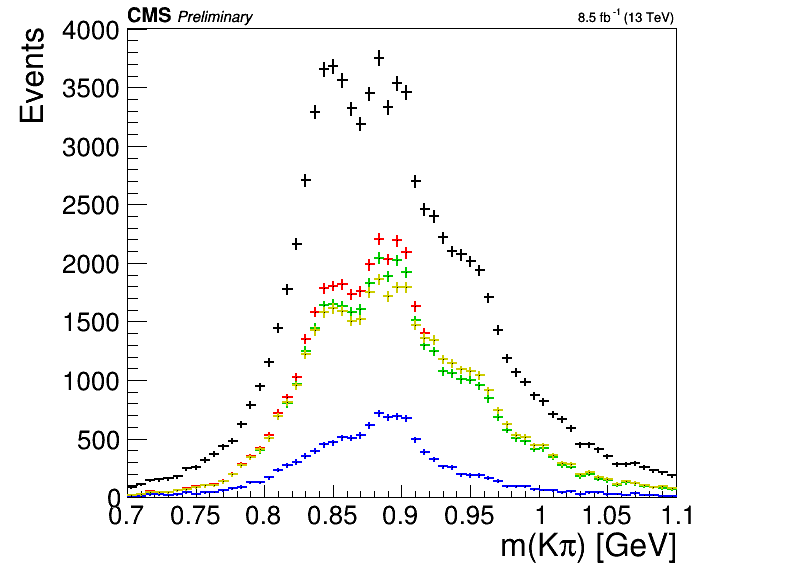

In [41]:
h = create_TH1D(d['mass_piK'][sel_prelim], 
                title='',
                axis_title=['m(K#pi) [GeV]', 'Events'],
                binning=[60, 0.7, 1.1]
               )
h.Sumw2()


sel_ExistB = np.logical_and(sel_prelim, d['pval_JpsiKst']>0.1)
sel_ExistB = np.logical_and(sel_ExistB, d['isValid_JpsiKst_cBMass'])
h3 = create_TH1D(d['mass_piK'][sel_ExistB], 
                title='',
                axis_title=['m(K#pi) [GeV]', 'Events'],
                binning=[60, 0.7, 1.1]
               )
h3.Sumw2()
h3.SetLineColor(rt.kBlue)

sel_ExistB = np.logical_and(sel_prelim, d['pval_mumupiK']>0.1)
h4 = create_TH1D(d['mass_piK'][sel_ExistB], 
                title='',
                axis_title=['m(K#pi) [GeV]', 'Events'],
                binning=[60, 0.7, 1.1]
               )
h4.Sumw2()
h4.SetLineColor(rt.kRed)

sel_noCP = np.logical_or(d['mass_piK_CPconj'] < 0.877, d['mass_piK_CPconj'] > 0.907)
sel_noCP = np.logical_and(sel_noCP, sel_ExistB)
h5 = create_TH1D(d['mass_piK'][sel_noCP], 
                title='',
                axis_title=['m(K#pi) [GeV]', 'Events'],
                binning=[60, 0.7, 1.1]
               )
h5.Sumw2()
h5.SetLineColor(rt.kGreen+1)

sel_KK = np.logical_or(d['mass_KK'] < 1.065, d['mass_KK'] > 1.08)
sel_KK = np.logical_and(sel_KK, sel_ExistB)
h6 = create_TH1D(d['mass_piK'][sel_KK], 
                title='',
                axis_title=['m(K#pi) [GeV]', 'Events'],
                binning=[60, 0.7, 1.1]
               )
h6.Sumw2()
h6.SetLineColor(rt.kYellow+1)
                                   
c = drawOnCMSCanvas(CMS_lumi, [h, h3, h4, h5, h6], 'same')
c.SetRightMargin(0.15)
c.Draw()
# c.SetLogy()

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


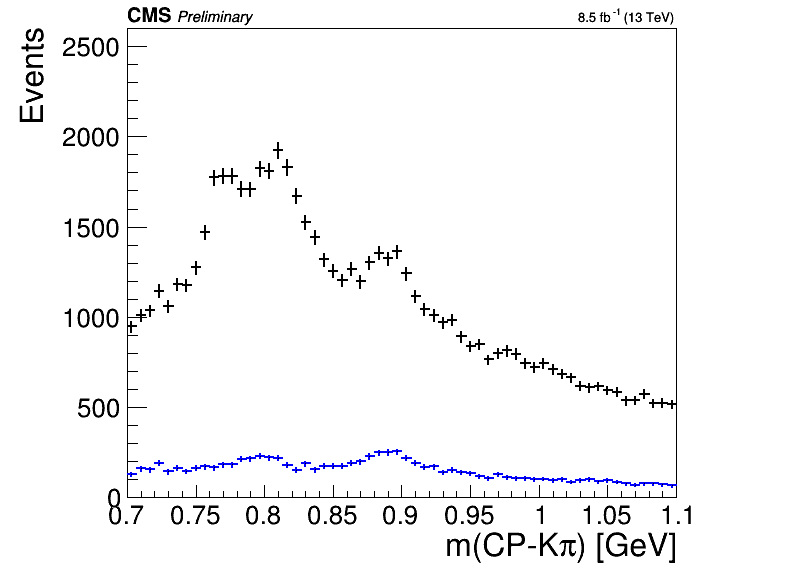

In [16]:
h = create_TH1D(d['mass_piK_CPconj'][sel_prelim], 
                title='',
                axis_title=['m(CP-K#pi) [GeV]', 'Events'],
                binning=[60, 0.7, 1.1]
               )
h.Sumw2()


sel_ExistB = np.logical_and(sel_prelim, d['pval_JpsiKst']>0.1)
sel_ExistB = np.logical_and(sel_ExistB, d['isValid_JpsiKst_cBMass'])
h3 = create_TH1D(d['mass_piK_CPconj'][sel_ExistB], 
                title='',
                axis_title=['m(CP-K#pi) [GeV]', 'Events'],
                binning=[60, 0.7, 1.1]
               )
h3.Sumw2()
h3.SetLineColor(rt.kBlue)

                                   
c = drawOnCMSCanvas(CMS_lumi, [h, h3], 'same')
c.SetRightMargin(0.15)
c.Draw()
h.GetYaxis().SetRangeUser(0, 2600)
# c.SetLogy()

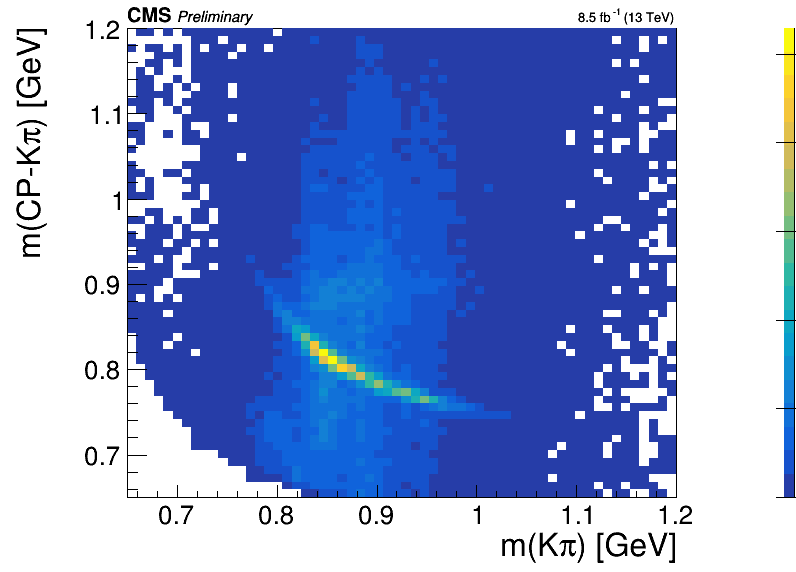

In [17]:
h = create_TH2D(np.column_stack((d['mass_piK'][sel_prelim], d['mass_piK_CPconj'][sel_prelim])),
                title='',
                axis_title=['m(K#pi) [GeV]', 'm(CP-K#pi) [GeV]', 'Events'],
                binning=[60, 0.65, 1.2, 60, 0.65, 1.2]
               )
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.Draw()
# c.SetLogy()

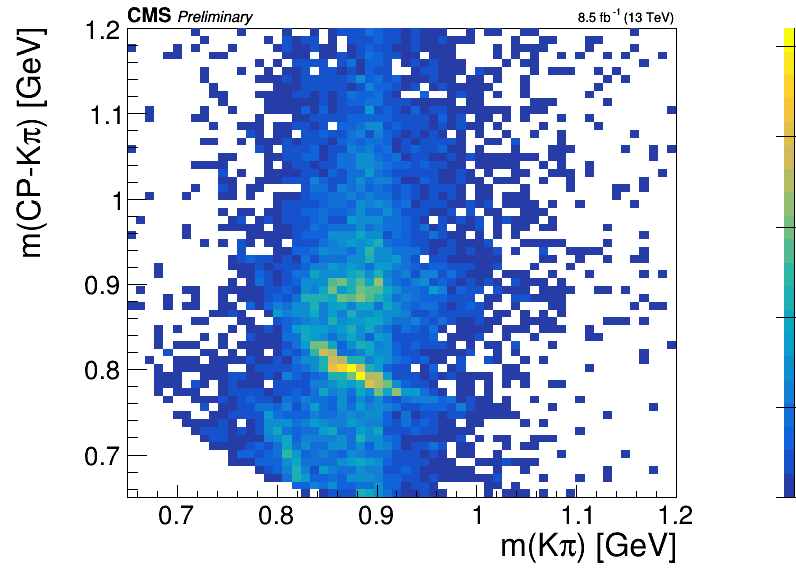

In [18]:
h = create_TH2D(np.column_stack((d['mass_piK'][sel_ExistB], d['mass_piK_CPconj'][sel_ExistB])),
                title='',
                axis_title=['m(K#pi) [GeV]', 'm(CP-K#pi) [GeV]', 'Events'],
                binning=[60, 0.65, 1.2, 60, 0.65, 1.2]
               )
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.Draw()

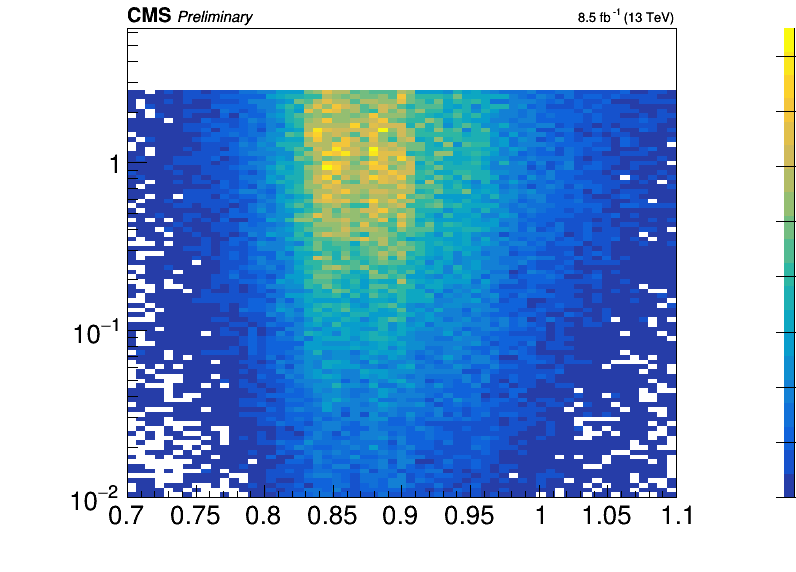

In [19]:
h = create_TH2D(np.column_stack((d['mass_piK'][sel_prelim], d['chi2_piK'][sel_prelim])), 
                title='',
#                 axis_title=['m(J/#psi K*) [GeV]', 'Events'],
                binning=[np.linspace(0.7, 1.1, 60), np.logspace(-2, 0.8, 100)]
               )

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.SetLogy()
c.Draw()

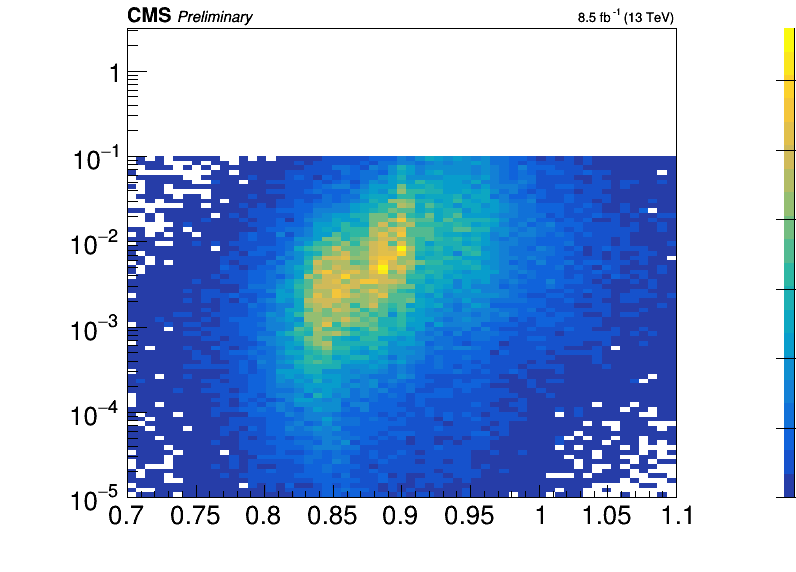

In [20]:
h = create_TH2D(np.column_stack((d['mass_piK'][sel_prelim], 1-d['cos_Kst_PV'][sel_prelim])), 
                title='',
#                 axis_title=['m(J/#psi K*) [GeV]', 'Events'],
                binning=[np.linspace(0.7, 1.1, 60), np.logspace(-5, 0.5, 100)]
               )

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.SetLogy()
c.Draw()

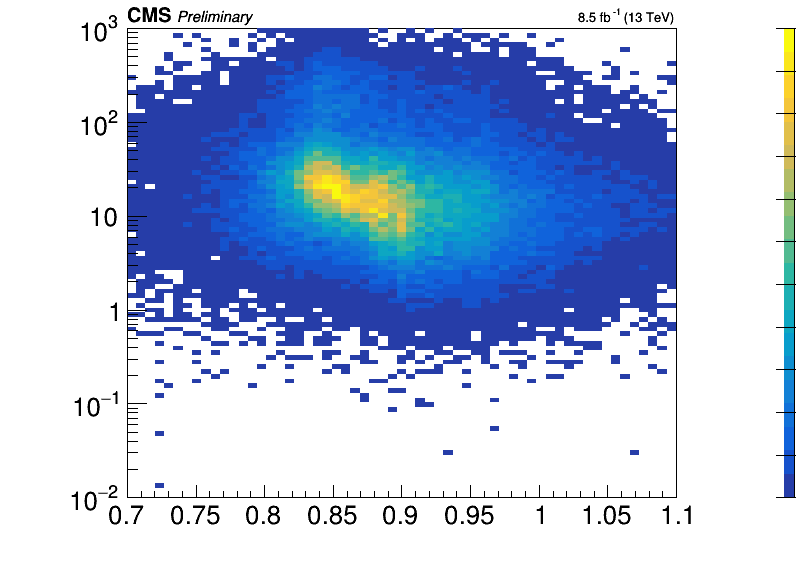

In [21]:
h = create_TH2D(np.column_stack((d['mass_piK'][sel_prelim], d['sigd_vtxKst_PV'][sel_prelim])), 
                title='',
#                 axis_title=['m(J/#psi K*) [GeV]', 'Events'],
                binning=[np.linspace(0.7, 1.1, 60), np.logspace(-2, 3, 100)]
               )

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.SetLogy()
c.Draw()

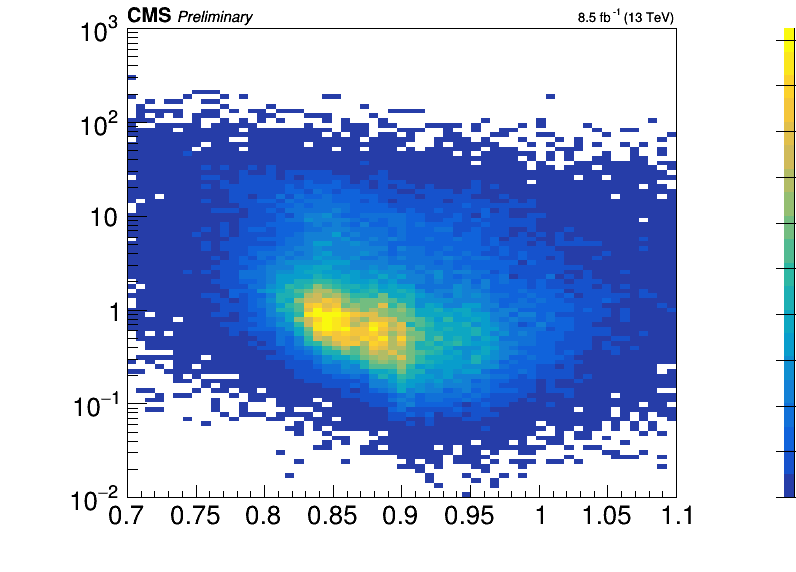

In [22]:
h = create_TH2D(np.column_stack((d['mass_piK'][sel_prelim], d['d_vtxKst_PV'][sel_prelim])), 
                title='',
#                 axis_title=['m(J/#psi K*) [GeV]', 'Events'],
                binning=[np.linspace(0.7, 1.1, 60), np.logspace(-2, 3, 100)]
               )

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.SetLogy()
c.Draw()

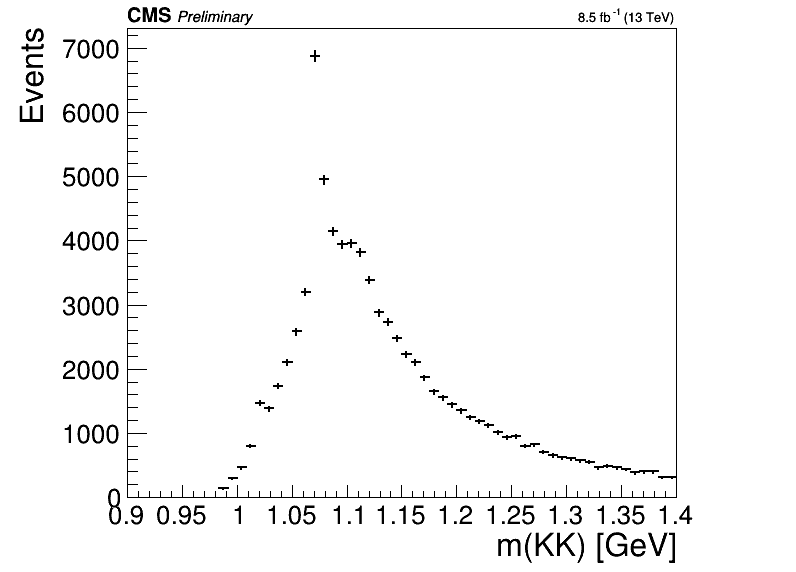

In [23]:
h = create_TH1D(d['mass_KK'][sel_prelim], 
                title='',
                axis_title=['m(KK) [GeV]', 'Events'],
                binning=[60, 0.9, 1.4]
               )
h.Sumw2()
                                   
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.SetRightMargin(0.15)
c.Draw()

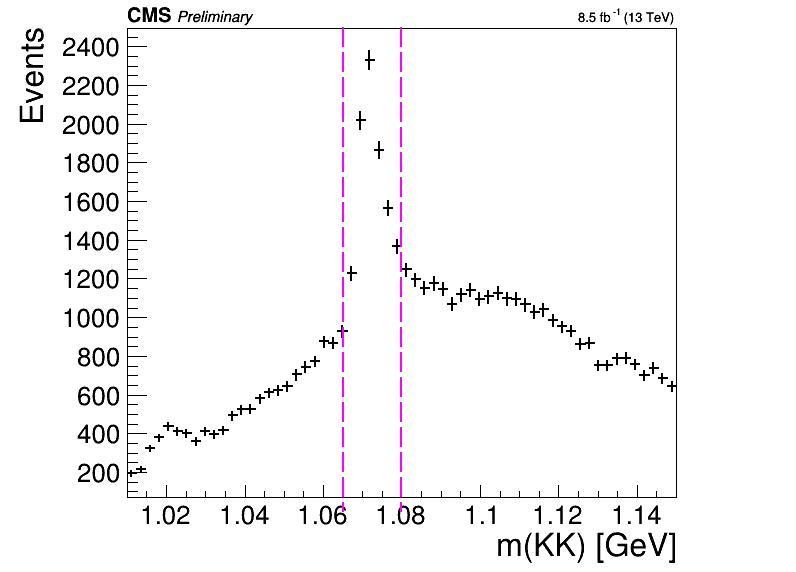

In [40]:
h = create_TH1D(d['mass_KK'][sel_prelim], 
                title='',
                axis_title=['m(KK) [GeV]', 'Events'],
                binning=[60, 1.01, 1.15]
               )
h.Sumw2()
                                   
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.SetRightMargin(0.15)
cl.DrawLine(1.065, 0, 1.065, 2500)
cl.DrawLine(1.08, 0, 1.08, 2500)
c.Draw()

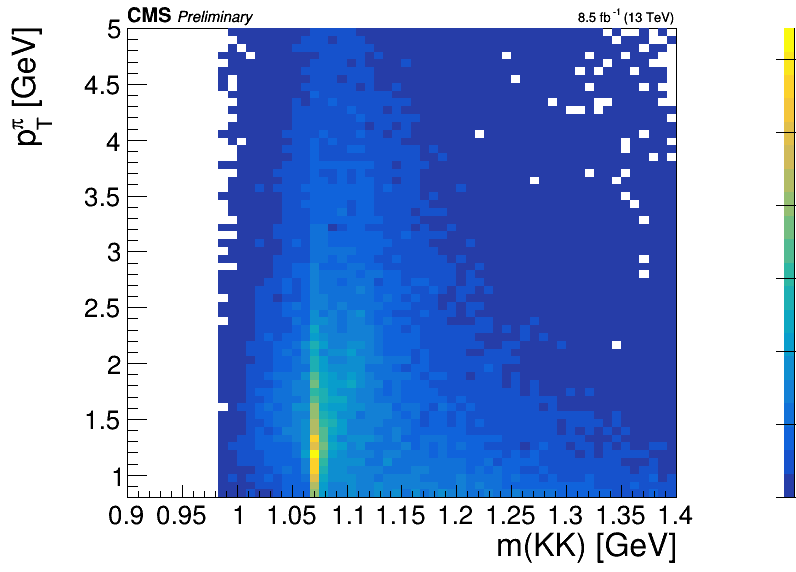

In [24]:
h = create_TH2D(np.column_stack((d['mass_KK'][sel_prelim], d['pi_pt'][sel_prelim])),
                title='',
                axis_title=['m(KK) [GeV]', 'p_{T}^{#pi} [GeV]', 'Events'],
                binning=[60, 0.9, 1.4, 60, 0.8, 5]
               )
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.Draw()

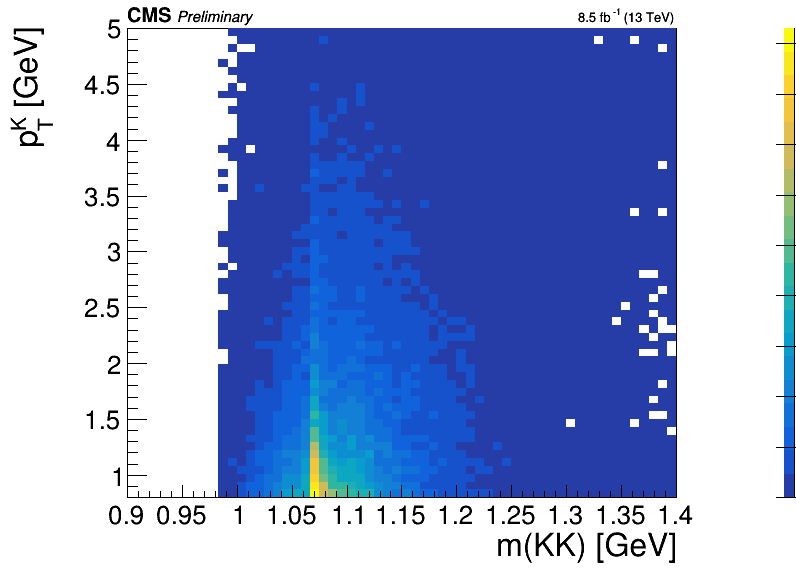

In [25]:
h = create_TH2D(np.column_stack((d['mass_KK'][sel_prelim], d['K_pt'][sel_prelim])),
                title='',
                axis_title=['m(KK) [GeV]', 'p_{T}^{K} [GeV]', 'Events'],
                binning=[60, 0.9, 1.4, 60, 0.8, 5]
               )
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.Draw()

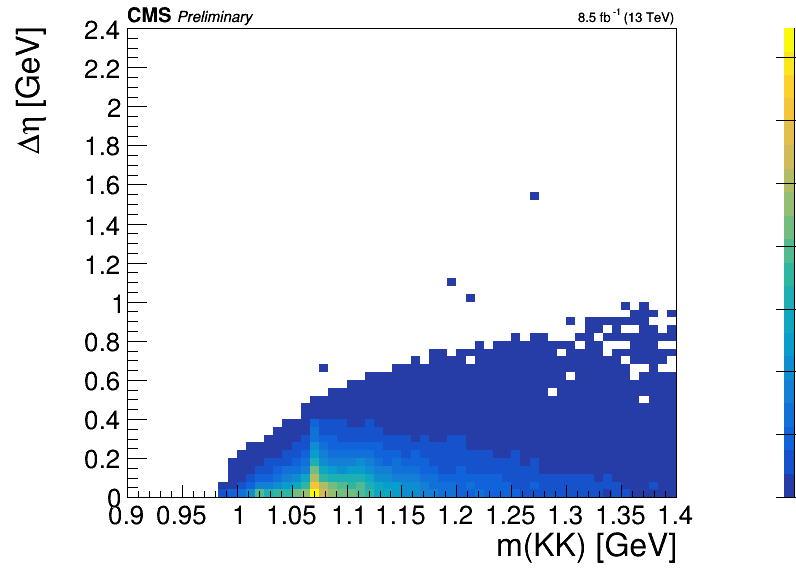

In [26]:
h = create_TH2D(np.column_stack((d['mass_KK'][sel_prelim], np.abs(d['K_eta'][sel_prelim]-d['pi_eta'][sel_prelim]))),
                title='',
                axis_title=['m(KK) [GeV]', '#Delta#eta [GeV]', 'Events'],
                binning=[60, 0.9, 1.4, 60, 0, 2.4]
               )
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.Draw()

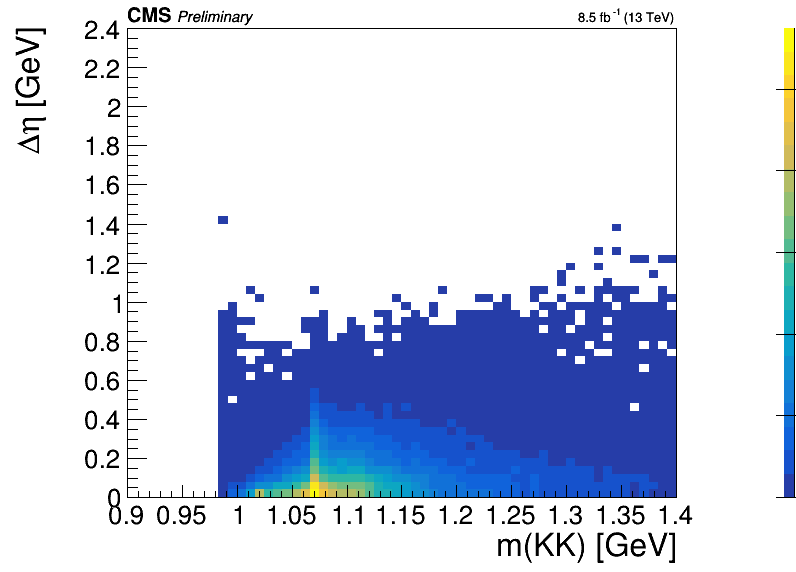

In [27]:
h = create_TH2D(np.column_stack((d['mass_KK'][sel_prelim], np.abs(d['K_phi'][sel_prelim]-d['pi_phi'][sel_prelim]))),
                title='',
                axis_title=['m(KK) [GeV]', '#Delta#eta [GeV]', 'Events'],
                binning=[60, 0.9, 1.4, 60, 0, 2.4]
               )
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.Draw()

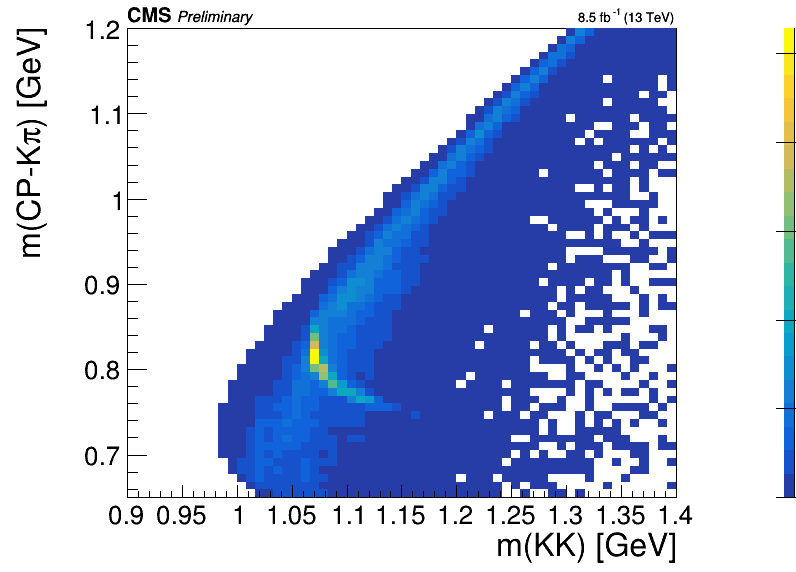

In [28]:
h = create_TH2D(np.column_stack((d['mass_KK'][sel_prelim], d['mass_piK_CPconj'][sel_prelim])),
                title='',
                axis_title=['m(KK) [GeV]', 'm(CP-K#pi) [GeV]', 'Events'],
                binning=[60, 0.9, 1.4, 60, 0.65, 1.2]
               )
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.Draw()

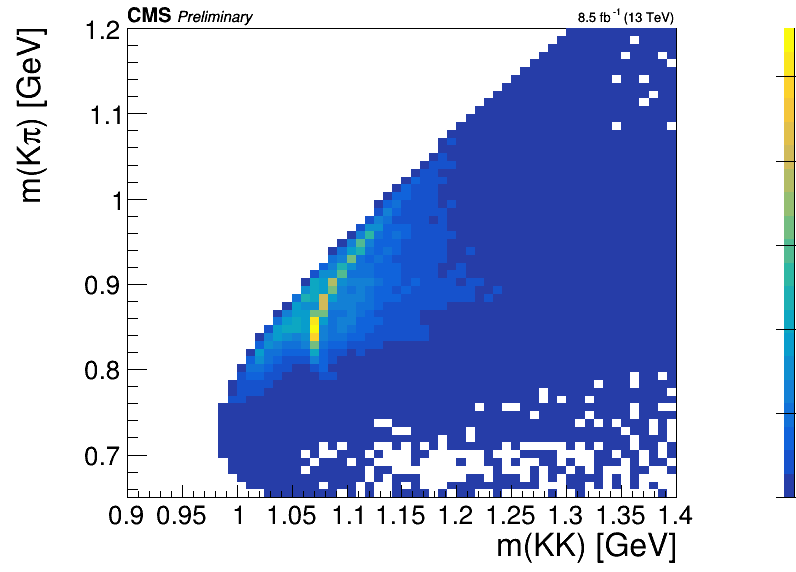

In [29]:
h = create_TH2D(np.column_stack((d['mass_KK'][sel_prelim], d['mass_piK'][sel_prelim])),
                title='',
                axis_title=['m(KK) [GeV]', 'm(K#pi) [GeV]', 'Events'],
                binning=[60, 0.9, 1.4, 60, 0.65, 1.2]
               )
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.Draw()

# Full analysis

In [30]:
cut['mass_KK'] = ['>',  1.035] #reject the phi->KK
cut['mass_mumu'] = ['<',  3.2]
cut['_mass_mumu'] = ['>',  3.0]
cut['mass_piK'] = ['<',  0.96]
cut['_mass_piK'] = ['>',  0.8]
sel_an, eff = createSel(d, cut)
print eff

0.05211161998946216


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


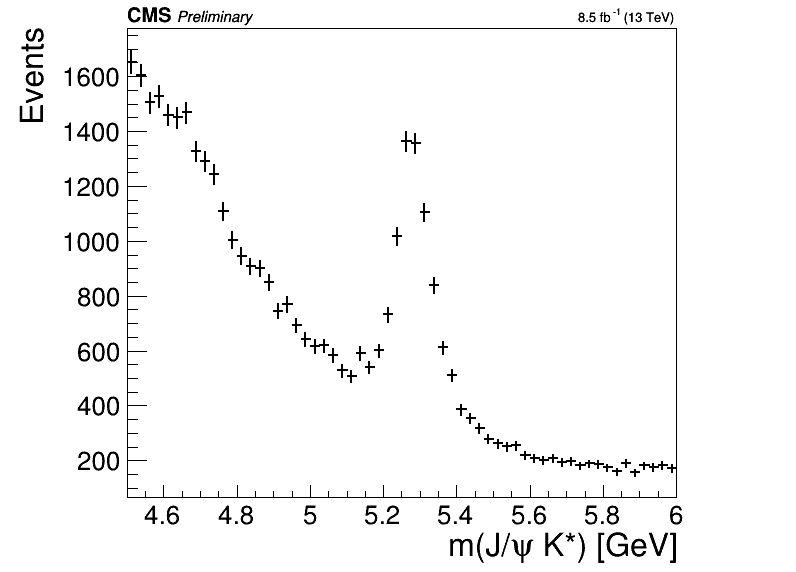

In [31]:
h = create_TH1D(d['mass_JpsiKst'][sel_an], 
                title='',
                axis_title=['m(J/#psi K*) [GeV]', 'Events'],
                binning=[60,4.5, 6]
               )
h.Sumw2()
                                   
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.SetRightMargin(0.15)
c.Draw()

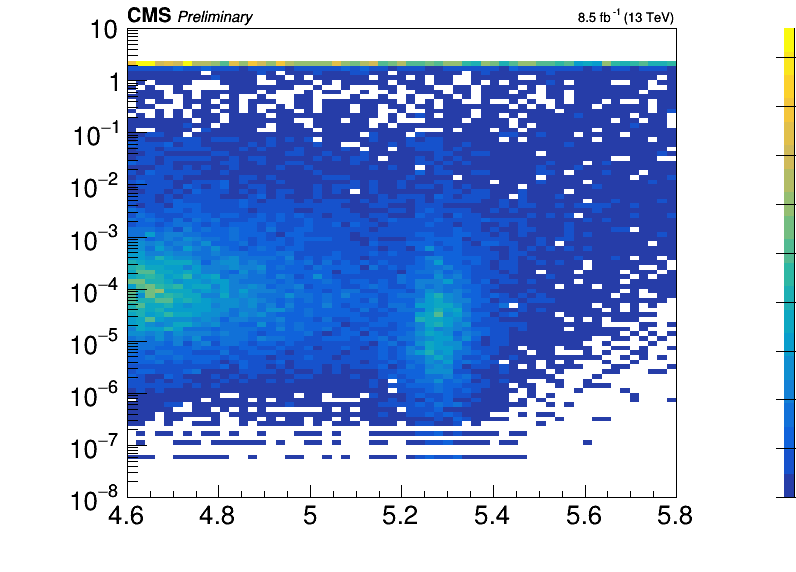

In [32]:
h = create_TH2D(np.column_stack((d['mass_JpsiKst'][sel_an], 1-d['cos_B_PV_JpsiKst'][sel_an])), 
                title='',
#                 axis_title=['m(J/#psi K*) [GeV]', 'Events'],
                binning=[np.linspace(4.6, 5.8, 60), np.logspace(-8, 1, 100)]
               )

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.SetLogy()
c.Draw()

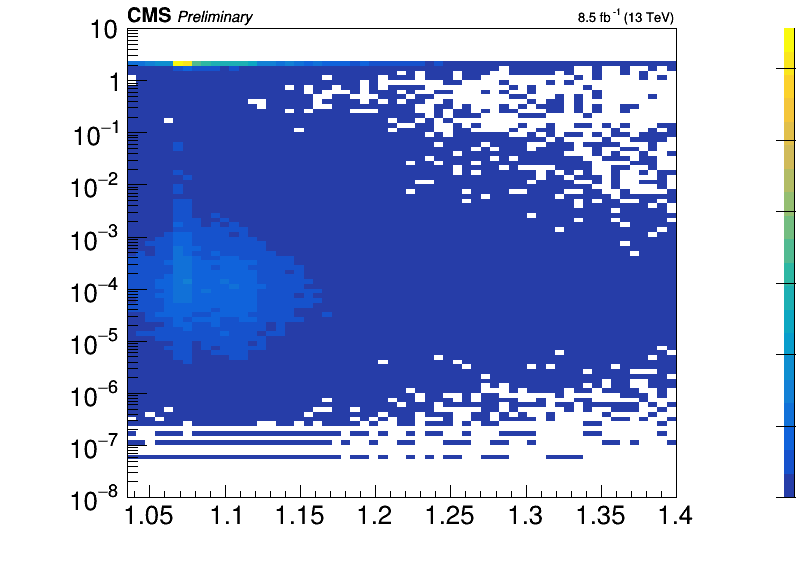

In [50]:
h = create_TH2D(np.column_stack((d['mass_KK'][sel_an], 1-d['cos_B_PV_JpsiKst'][sel_an])), 
                title='',
#                 axis_title=['m(J/#psi K*) [GeV]', 'Events'],
                binning=[np.linspace(1.035, 1.4, 60), np.logspace(-8, 1, 100)]
               )

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.SetLogy()
c.Draw()

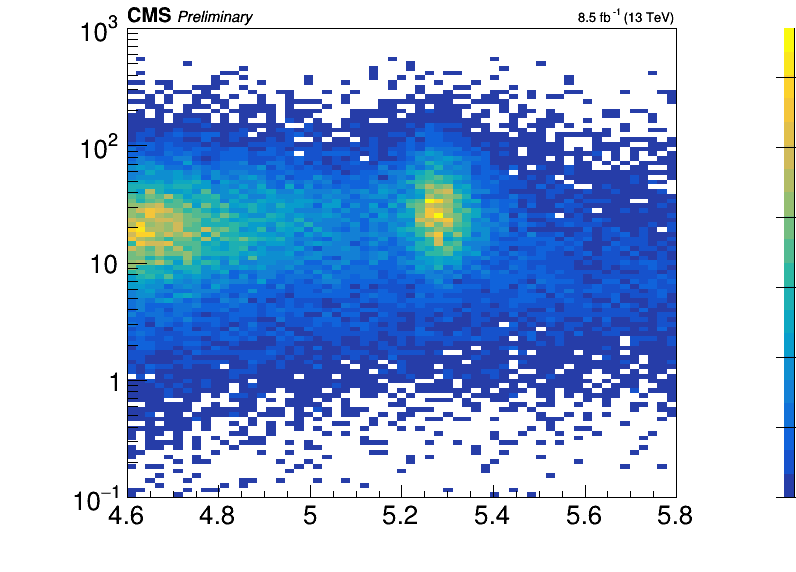

In [33]:
h = create_TH2D(np.column_stack((d['mass_JpsiKst'][sel_an], d['sigd_vtxB_PV_JpsiKst'][sel_an])), 
                title='',
#                 axis_title=['m(J/#psi K*) [GeV]', 'Events'],
                binning=[np.linspace(4.6, 5.8, 60), np.logspace(-1, 3, 100)]
               )

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.SetLogy()
c.Draw()

In [34]:
cut['cos_B_PV_JpsiKst'] = ['>',  0.99]
sel_an_imp, eff = createSel(d, cut)
print eff

0.04175785946851484


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


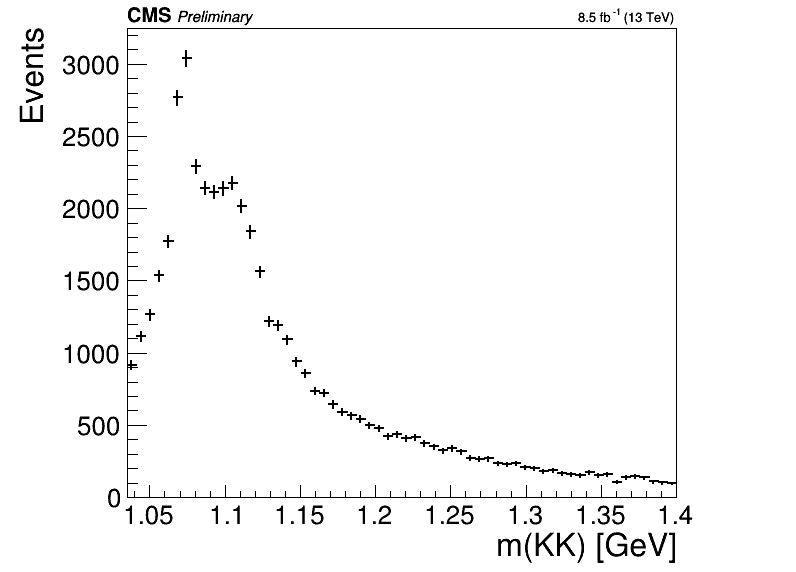

In [51]:
h = create_TH1D(d['mass_KK'][sel_an_imp], 
                title='',
                axis_title=['m(KK) [GeV]', 'Events'],
                binning=[60,1.035, 1.4]
               )
h.Sumw2()
                                   
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.SetRightMargin(0.15)
c.Draw()

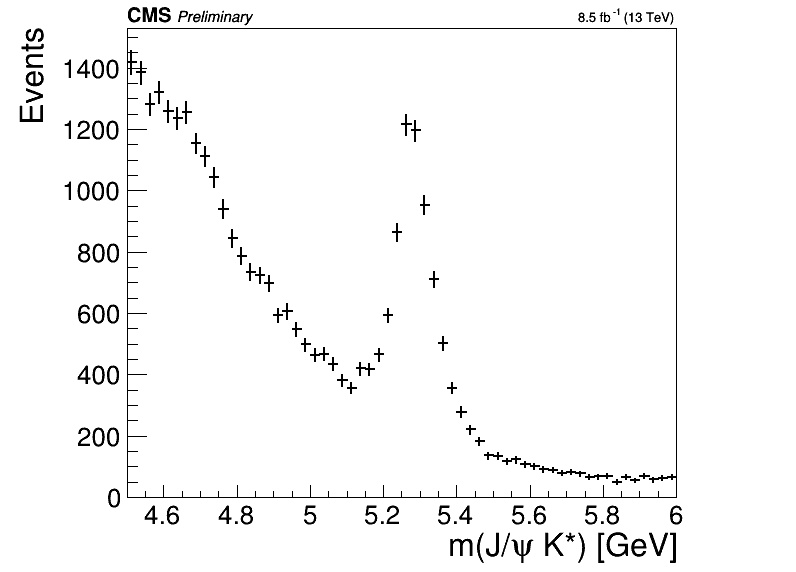

In [35]:
h = create_TH1D(d['mass_JpsiKst'][sel_an_imp], 
                title='',
                axis_title=['m(J/#psi K*) [GeV]', 'Events'],
                binning=[60,4.5, 6]
               )
h.Sumw2()
                                   
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.SetRightMargin(0.15)
c.Draw()

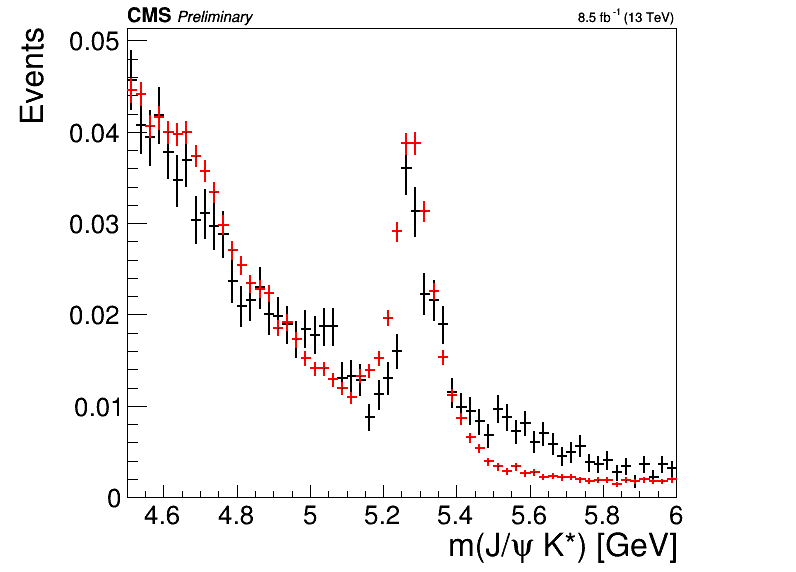

In [48]:
sel_KK_peak = np.logical_and(d['mass_KK'] > 1.065, d['mass_KK'] < 1.08)
sel_KK_peak = np.logical_and(sel_KK_peak, sel_an_imp)
h = create_TH1D(d['mass_JpsiKst'][sel_KK_peak], 
                title='',
                axis_title=['m(J/#psi K*) [GeV]', 'Events'],
                binning=[60,4.5, 6]
               )
h.Sumw2()
h.Scale(1./h.Integral())

sel_KK_NOpeak = np.logical_or(d['mass_KK'] < 1.065, d['mass_KK'] > 1.08)
sel_KK_NOpeak = np.logical_and(sel_KK_NOpeak, sel_an_imp)
h2 = create_TH1D(d['mass_JpsiKst'][sel_KK_NOpeak], 
                title='',
                axis_title=['m(J/#psi K*) [GeV]', 'Events'],
                binning=[60,4.5, 6]
               )
h2.Sumw2()
h2.SetLineColor(rt.kRed)
h2.Scale(1./h2.Integral())
                                   
c = drawOnCMSCanvas(CMS_lumi, [h, h2], 'same')
c.SetRightMargin(0.15)
c.Draw()

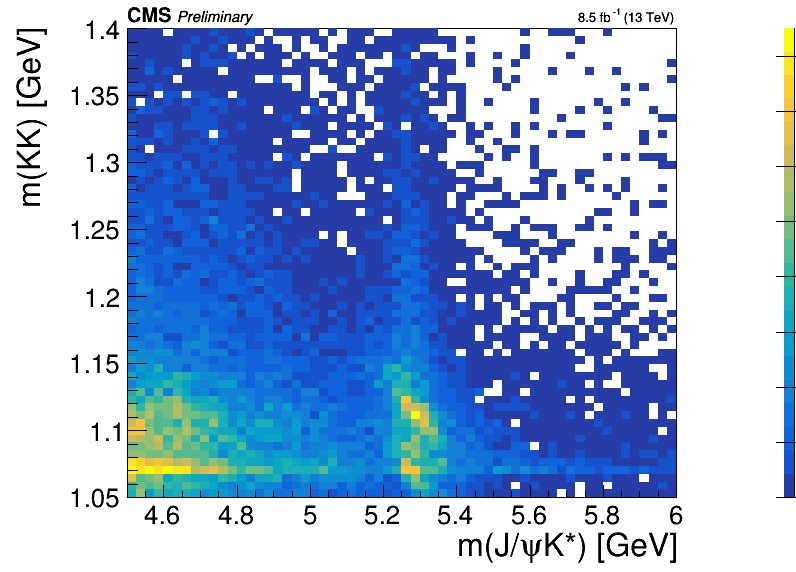

In [46]:
h = create_TH2D(np.column_stack((d['mass_JpsiKst'][sel_an_imp], d['mass_KK'][sel_an_imp])),
                title='',
                axis_title=['m(J/#psiK*) [GeV]', 'm(KK) [GeV]', 'Events'],
                binning=[60,4.5, 6, 60, 1.05, 1.4]
               )
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.Draw()

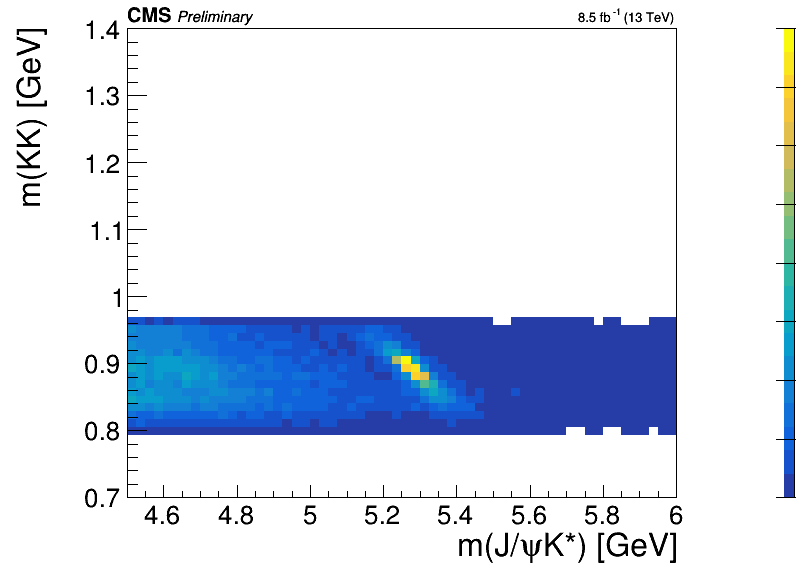

In [52]:
h = create_TH2D(np.column_stack((d['mass_JpsiKst'][sel_an_imp], d['mass_piK'][sel_an_imp])),
                title='',
                axis_title=['m(J/#psiK*) [GeV]', 'm(KK) [GeV]', 'Events'],
                binning=[60,4.5, 6, 60, 0.7, 1.4]
               )
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.Draw()